In [1]:
!pip -qq install torchutils mplcyberpunk seaborn mlflow

In [2]:
!pip install kaggle

  Using cached bleach-6.3.0-py3-none-any.whl.metadata (31 kB)
  Using cached python_slugify-8.0.4-py2.py3-none-any.whl.metadata (8.5 kB)
  Using cached webencodings-0.5.1-py2.py3-none-any.whl.metadata (2.1 kB)
  Using cached text_unidecode-1.3-py2.py3-none-any.whl.metadata (2.4 kB)
Using cached bleach-6.3.0-py3-none-any.whl (164 kB)
Using cached python_slugify-8.0.4-py2.py3-none-any.whl (10 kB)
Using cached text_unidecode-1.3-py2.py3-none-any.whl (78 kB)
Using cached webencodings-0.5.1-py2.py3-none-any.whl (11 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [kaggle]2m4/5 [kaggle]


In [3]:
import torch
import torchvision
import torch.nn as nn
import time
import os
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms as T
from torchvision.models import resnet18, ResNet18_Weights
from collections import Counter

# Для чтения изображений с диска
from torchvision import io # input/output
import torchutils as tu
import json
import mplcyberpunk
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import f1_score, confusion_matrix

import mlflow
import mlflow.pytorch
import random

from sklearn.metrics import confusion_matrix

torch.manual_seed(42)
plt.style.use('cyberpunk')

/home/lesia/DS/projects/phase 2 week 1/nn_project_stars_25/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cuda


In [16]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"lesiasa","key":"010a9696c11aa0763775a8ee294fa5b1"}'}

In [17]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [18]:
!kaggle datasets download -d paultimothymooney/blood-cells
!unzip blood-cells.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8050.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8167.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8283.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8324.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8379.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8577.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8587.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8655.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8701.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_872.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8864.jpeg  
  inflati

In [19]:
!ls dataset2-master/dataset2-master/images


TEST  TEST_SIMPLE  TRAIN


In [20]:
if os.path.exists("../data/dataset2-master/dataset2-master/images"):
    # локальный запуск
    base_path = "../data/dataset2-master/dataset2-master/images"
else:
    # Colab
    base_path = "dataset2-master/dataset2-master/images"

train_dir = os.path.join(base_path, "TRAIN")
test_dir = os.path.join(base_path, "TEST")


In [21]:
weights = ResNet18_Weights.DEFAULT
preprocess = weights.transforms()

full_train_dataset = datasets.ImageFolder(train_dir, transform=preprocess)

n_total = len(full_train_dataset)
n_train = int(0.8 * n_total)
n_val   = n_total - n_train

train_dataset, val_dataset = random_split(
    full_train_dataset,
    [n_train, n_val],
    generator=torch.Generator().manual_seed(42)
)

test_dataset = datasets.ImageFolder(test_dir, transform=preprocess)

In [22]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [23]:
class_names = full_train_dataset.classes
n_classes = len(class_names)

In [24]:
counts = Counter(full_train_dataset.targets)

for idx, count in counts.items():
    print(class_names[idx], count)

EOSINOPHIL 2497
LYMPHOCYTE 2483
MONOCYTE 2478
NEUTROPHIL 2499


In [25]:
print("Total samples:", len(full_train_dataset))
print("Train size:", len(train_dataset))
print("Validation size:", len(val_dataset))
print("Test size:", len(test_dataset))

Total samples: 9957
Train size: 7965
Validation size: 1992
Test size: 2487


In [26]:
model = resnet18(weights=weights)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 178MB/s]


In [27]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [28]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [29]:
for param in model.parameters():
    param.requires_grad = False

In [30]:
model.fc = nn.Linear(model.fc.in_features, n_classes)

In [31]:
model = model.to(DEVICE)

In [32]:
for param in model.parameters():
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True


In [33]:
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [34]:
def fit(
    model: torch.nn.Module,
    n_epochs: int,
    optimizer: torch.optim.Optimizer,
    train_loader: DataLoader,
    valid_loader: DataLoader
):

    train_losses = []
    valid_losses = []
    train_f1 = []
    valid_f1 = []

    for epoch in range(n_epochs):

        # ===== TRAIN =====
        model.train()
        batch_loss = []

        all_preds = []
        all_labels = []

        for images, labels in train_loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            preds = model(images)
            loss = criterion(preds, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_loss.append(loss.item())

            predicted = preds.argmax(dim=1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        train_losses.append(np.mean(batch_loss))
        train_f1.append(
            f1_score(all_labels, all_preds, average="macro")
        )

        # ===== VALID =====
        model.eval()
        batch_loss = []

        all_preds = []
        all_labels = []

        with torch.no_grad():
            for images, labels in valid_loader:
                images = images.to(DEVICE)
                labels = labels.to(DEVICE)

                preds = model(images)
                loss = criterion(preds, labels)

                batch_loss.append(loss.item())

                predicted = preds.argmax(dim=1)

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        valid_losses.append(np.mean(batch_loss))
        valid_f1.append(
            f1_score(all_labels, all_preds, average="macro")
        )

        print(f"Epoch {epoch+1}/{n_epochs}")
        print(f"Train loss: {train_losses[-1]:.4f} | Train F1: {train_f1[-1]:.4f}")
        print(f"Valid loss: {valid_losses[-1]:.4f} | Valid F1: {valid_f1[-1]:.4f}")
        print("-" * 40)

    return train_losses, valid_losses, train_f1, valid_f1


In [35]:
def evaluate(model: torch.nn.Module, test_loader: DataLoader):

    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            preds = model(images)
            predicted = preds.argmax(dim=1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    f1 = f1_score(all_labels, all_preds, average="macro")
    cm = confusion_matrix(all_labels, all_preds)

    return f1, cm

In [36]:
def show_predictions(model, dataset, idx2class, DEVICE, n_images=6):

    model.eval()

    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes = axes.flatten()

    for i in range(n_images):
        idx = random.randint(0, len(dataset) - 1)

        # Получаем данные
        img_tensor, true_label = dataset[idx]

        # Если dataset — это Subset (после random_split)
        if hasattr(dataset, "indices"):
            real_idx = dataset.indices[idx]
            img_path = dataset.dataset.samples[real_idx][0]
        else:
            img_path = dataset.samples[idx][0]

        orig_img = io.read_image(img_path)

        with torch.no_grad():
            logits = model(img_tensor.unsqueeze(0).to(DEVICE))
            probs = torch.softmax(logits, dim=1)
            confidence, pred_class = torch.max(probs, dim=1)

        confidence = confidence.item()
        pred_class = pred_class.item()

        color = "green" if pred_class == true_label else "red"

        axes[i].imshow(orig_img.permute(1, 2, 0))
        axes[i].set_title(
            f"{idx2class[pred_class]} | {confidence:.3f}",
            color=color
        )
        axes[i].axis("off")

        for spine in axes[i].spines.values():
            spine.set_edgecolor(color)
            spine.set_linewidth(3)

    plt.tight_layout()
    plt.show()


In [37]:
def plot_history(
    train_losses,
    valid_losses,
    train_f1,
    valid_f1,
    title="Training History",
    save_path=None
):

    epochs = range(1, len(train_losses) + 1)

    fig = plt.figure(figsize=(12,5))

    # ===== LOSS =====
    plt.subplot(1,2,1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, valid_losses, label="Valid Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss")
    plt.legend()

    # ===== F1 =====
    plt.subplot(1,2,2)
    plt.plot(epochs, train_f1, label="Train F1")
    plt.plot(epochs, valid_f1, label="Valid F1")
    plt.xlabel("Epoch")
    plt.ylabel("F1-score")
    plt.title("F1-score")
    plt.legend()

    plt.suptitle(title)
    plt.tight_layout()

    # ===== Сохранение =====
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()
    plt.close(fig)   # важно — чтобы не было утечки памяти

In [38]:
def plot_confusion_matrix(
    cm,
    class_names,
    title="Confusion Matrix",
    save_path=None
):

    fig = plt.figure(figsize=(6,5))

    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names
    )

    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()

    # ===== Сохранение =====
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()
    plt.close(fig)   # обязательно


In [39]:
idx2class = {v: k for k, v in full_train_dataset.class_to_idx.items()}

In [40]:
start1 = time.perf_counter()

In [41]:
train_losses1, val_losses1, train_f11, val_f11 = fit(
    model=model,
    n_epochs=5,
    optimizer=optimizer,
    train_loader=train_loader,
    valid_loader=valid_loader
)

Epoch 1/5
Train loss: 1.1090 | Train F1: 0.5288
Valid loss: 0.9289 | Valid F1: 0.6303
----------------------------------------
Epoch 2/5
Train loss: 0.8194 | Train F1: 0.7015
Valid loss: 0.7646 | Valid F1: 0.7152
----------------------------------------
Epoch 3/5
Train loss: 0.7260 | Train F1: 0.7347
Valid loss: 0.6930 | Valid F1: 0.7499
----------------------------------------
Epoch 4/5
Train loss: 0.6617 | Train F1: 0.7563
Valid loss: 0.6493 | Valid F1: 0.7601
----------------------------------------
Epoch 5/5
Train loss: 0.6303 | Train F1: 0.7693
Valid loss: 0.6470 | Valid F1: 0.7513
----------------------------------------


In [42]:
train_time1 = time.perf_counter() - start1

In [46]:
f1_test, cm1 = evaluate(model, test_loader)

print("Test F1:", f1_test)

Test F1: 0.6726835757104905


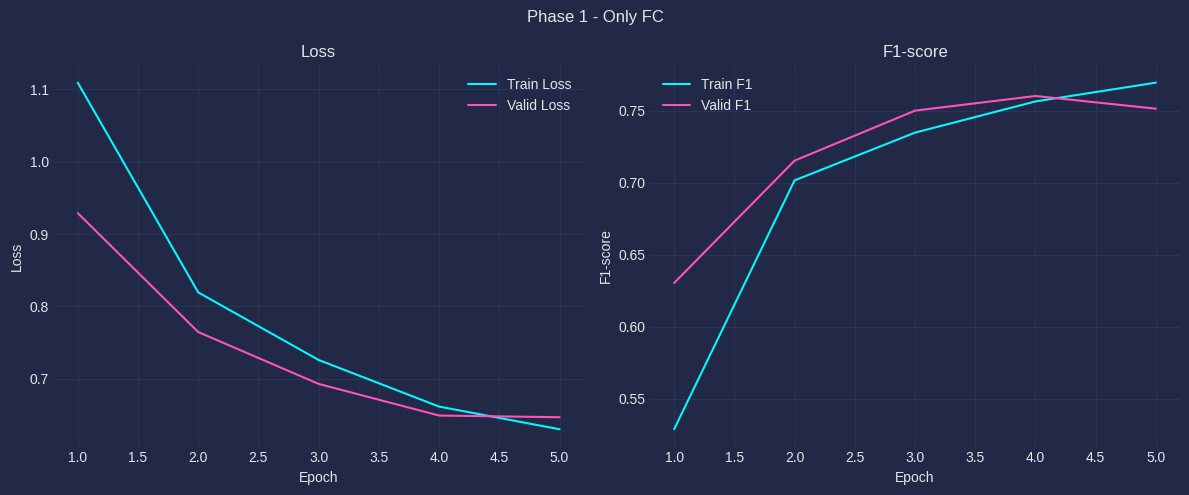

In [44]:
plot_history(
    train_losses1,
    val_losses1,
    train_f11,
    val_f11,
    title="Phase 1 - Only FC",
    save_path="history_phase1.png"
)

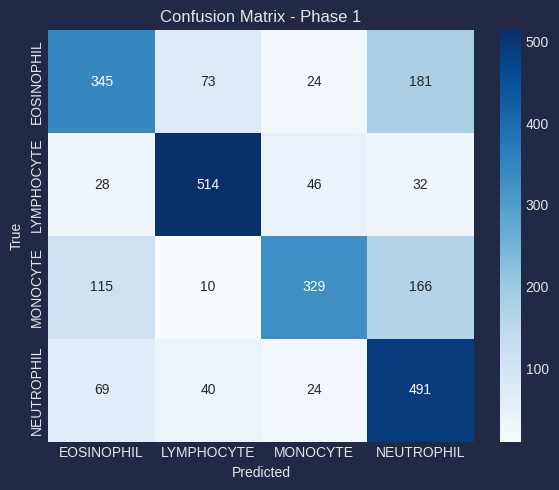

In [47]:
plot_confusion_matrix(
    cm1,
    class_names,
    title="Confusion Matrix - Phase 1",
    save_path="cm_phase1.png"
)

In [48]:
f1_before, cm_before = evaluate(model, test_loader)

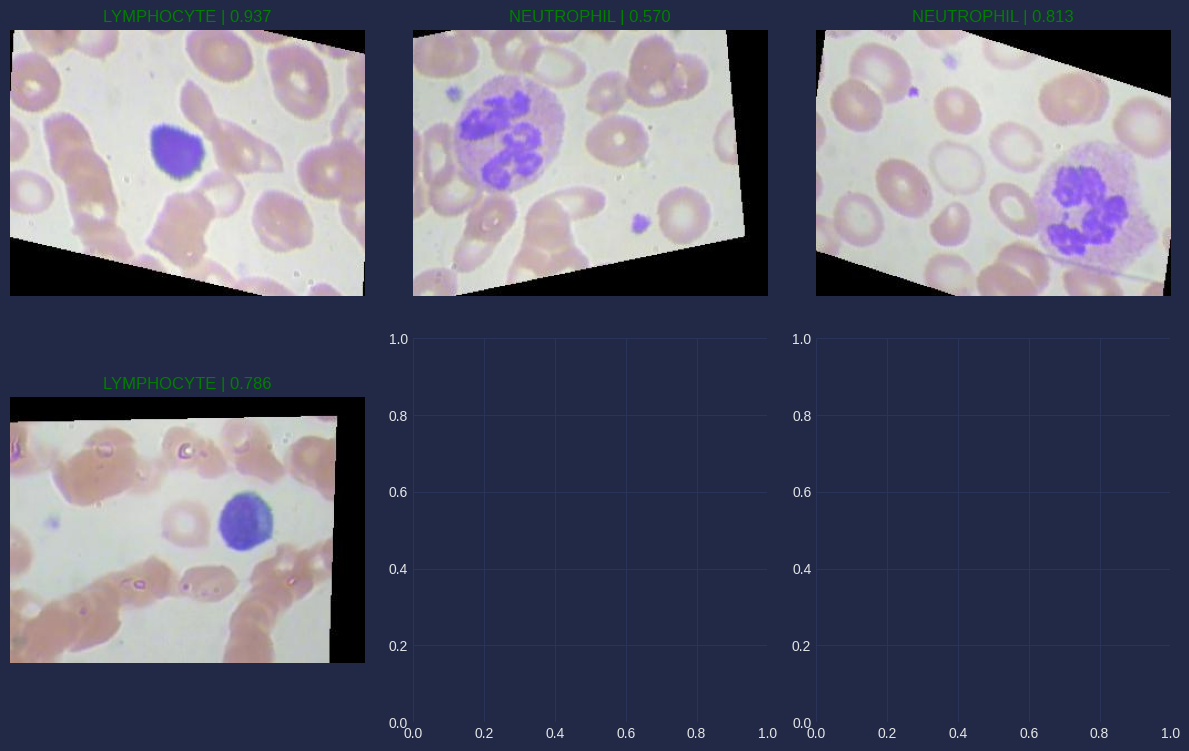

In [49]:
show_predictions(model, test_dataset, idx2class, DEVICE)


In [50]:
for param in model.layer4.parameters():
    param.requires_grad = True


In [51]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)


layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.weight
layer4.0.bn2.weight
layer4.0.bn2.bias
layer4.0.downsample.0.weight
layer4.0.downsample.1.weight
layer4.0.downsample.1.bias
layer4.1.conv1.weight
layer4.1.bn1.weight
layer4.1.bn1.bias
layer4.1.conv2.weight
layer4.1.bn2.weight
layer4.1.bn2.bias
fc.weight
fc.bias


In [52]:
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4
)

In [53]:
start2 = time.perf_counter()

In [54]:
train_losses2, val_losses2, train_f12, val_f12 = fit(
    model=model,
    n_epochs=8,
    optimizer=optimizer,
    train_loader=train_loader,
    valid_loader=valid_loader
)

Epoch 1/8
Train loss: 0.1872 | Train F1: 0.9313
Valid loss: 0.0652 | Valid F1: 0.9784
----------------------------------------
Epoch 2/8
Train loss: 0.0136 | Train F1: 0.9984
Valid loss: 0.0443 | Valid F1: 0.9864
----------------------------------------
Epoch 3/8
Train loss: 0.0035 | Train F1: 1.0000
Valid loss: 0.0358 | Valid F1: 0.9864
----------------------------------------
Epoch 4/8
Train loss: 0.0018 | Train F1: 1.0000
Valid loss: 0.0352 | Valid F1: 0.9869
----------------------------------------
Epoch 5/8
Train loss: 0.0010 | Train F1: 1.0000
Valid loss: 0.0333 | Valid F1: 0.9874
----------------------------------------
Epoch 6/8
Train loss: 0.0007 | Train F1: 1.0000
Valid loss: 0.0321 | Valid F1: 0.9880
----------------------------------------
Epoch 7/8
Train loss: 0.0005 | Train F1: 1.0000
Valid loss: 0.0316 | Valid F1: 0.9874
----------------------------------------
Epoch 8/8
Train loss: 0.0004 | Train F1: 1.0000
Valid loss: 0.0310 | Valid F1: 0.9889
-------------------------

In [55]:
train_time2 = time.perf_counter() - start2

In [56]:
f1_test, cm_after = evaluate(model, test_loader)

print("Test F1:", f1_test)

Test F1: 0.8238796947613329


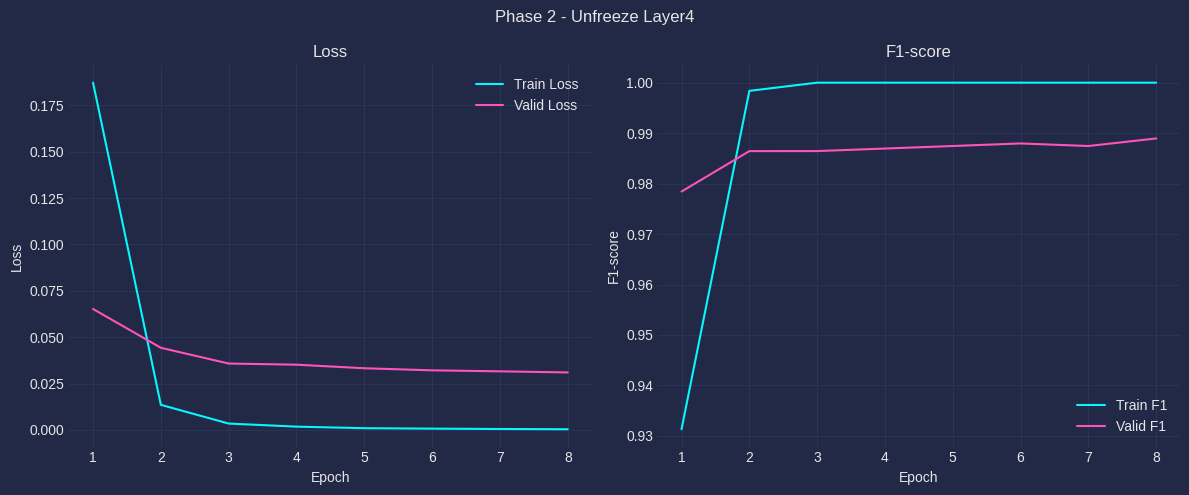

In [57]:
plot_history(
    train_losses2,
    val_losses2,
    train_f12,
    val_f12,
    title="Phase 2 - Unfreeze Layer4",
    save_path="history_phase2.png"
)

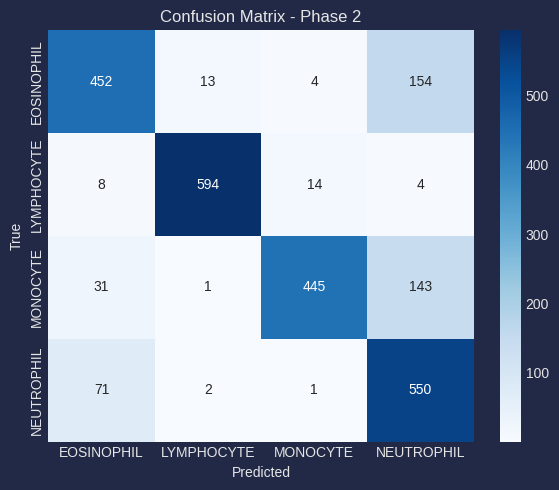

In [58]:
plot_confusion_matrix(
    cm_after,
    class_names,
    title="Confusion Matrix - Phase 2",
    save_path="cm_phase2.png"
)

In [59]:
f1_after, cm_after = evaluate(model, test_loader)

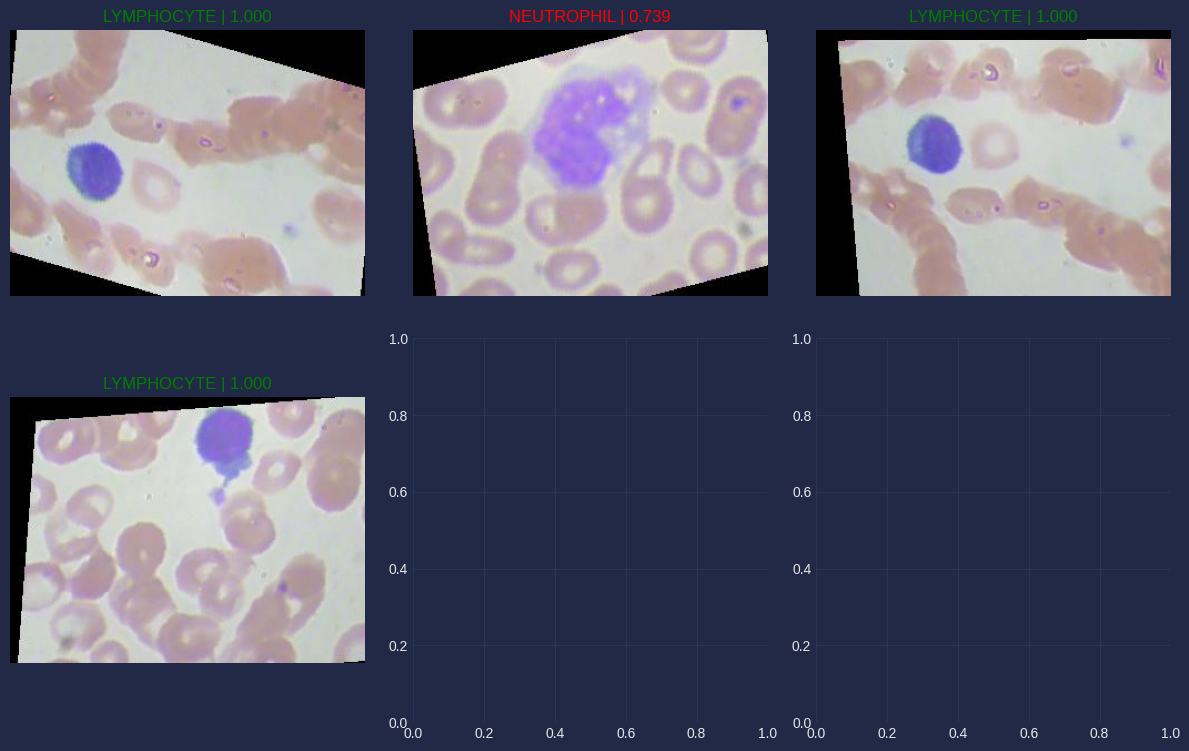

In [60]:
show_predictions(model, test_dataset, idx2class, DEVICE)


In [61]:
for param in model.layer3.parameters():
    param.requires_grad = True

In [62]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

layer3.0.conv1.weight
layer3.0.bn1.weight
layer3.0.bn1.bias
layer3.0.conv2.weight
layer3.0.bn2.weight
layer3.0.bn2.bias
layer3.0.downsample.0.weight
layer3.0.downsample.1.weight
layer3.0.downsample.1.bias
layer3.1.conv1.weight
layer3.1.bn1.weight
layer3.1.bn1.bias
layer3.1.conv2.weight
layer3.1.bn2.weight
layer3.1.bn2.bias
layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.weight
layer4.0.bn2.weight
layer4.0.bn2.bias
layer4.0.downsample.0.weight
layer4.0.downsample.1.weight
layer4.0.downsample.1.bias
layer4.1.conv1.weight
layer4.1.bn1.weight
layer4.1.bn1.bias
layer4.1.conv2.weight
layer4.1.bn2.weight
layer4.1.bn2.bias
fc.weight
fc.bias


In [63]:
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=5e-5
)

In [64]:
start3 = time.perf_counter()

In [65]:
train_losses3, val_losses3, train_f13, val_f13 = fit(
    model=model,
    n_epochs=10,
    optimizer=optimizer,
    train_loader=train_loader,
    valid_loader=valid_loader
)

Epoch 1/10
Train loss: 0.0008 | Train F1: 1.0000
Valid loss: 0.1368 | Valid F1: 0.9565
----------------------------------------
Epoch 2/10
Train loss: 0.0054 | Train F1: 0.9979
Valid loss: 0.1054 | Valid F1: 0.9710
----------------------------------------
Epoch 3/10
Train loss: 0.0104 | Train F1: 0.9972
Valid loss: 0.0399 | Valid F1: 0.9859
----------------------------------------
Epoch 4/10
Train loss: 0.0021 | Train F1: 0.9994
Valid loss: 0.0268 | Valid F1: 0.9899
----------------------------------------
Epoch 5/10
Train loss: 0.0008 | Train F1: 0.9999
Valid loss: 0.0205 | Valid F1: 0.9920
----------------------------------------
Epoch 6/10
Train loss: 0.0005 | Train F1: 1.0000
Valid loss: 0.0206 | Valid F1: 0.9905
----------------------------------------
Epoch 7/10
Train loss: 0.0002 | Train F1: 1.0000
Valid loss: 0.0197 | Valid F1: 0.9925
----------------------------------------
Epoch 8/10
Train loss: 0.0001 | Train F1: 1.0000
Valid loss: 0.0195 | Valid F1: 0.9915
-----------------

In [66]:
train_time3 = time.perf_counter() - start3

In [67]:
f1_after3, cm_after3 = evaluate(model, test_loader)

print("Test F1 after phase 3:", f1_after3)

Test F1 after phase 3: 0.8279485313069539


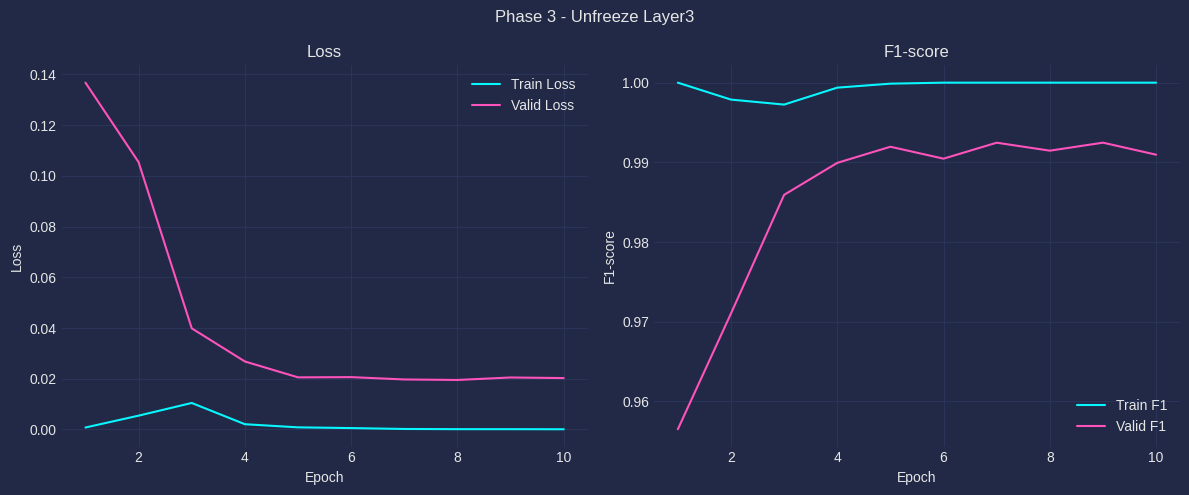

In [68]:
plot_history(
    train_losses3,
    val_losses3,
    train_f13,
    val_f13,
    title="Phase 3 - Unfreeze Layer3",
    save_path="history_phase3.png"
)

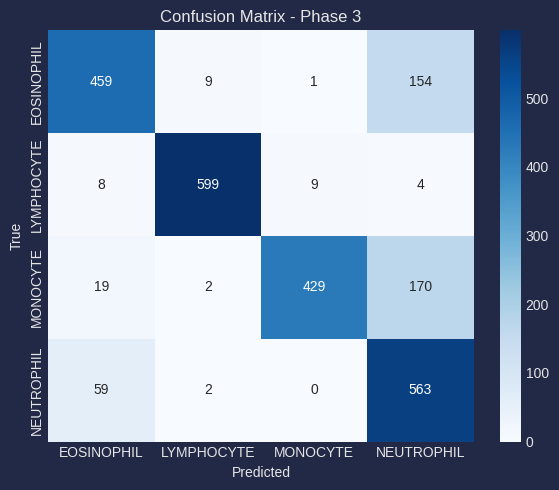

In [69]:
plot_confusion_matrix(
    cm_after3,
    class_names,
    title="Confusion Matrix - Phase 3",
    save_path="cm_phase3.png"
)

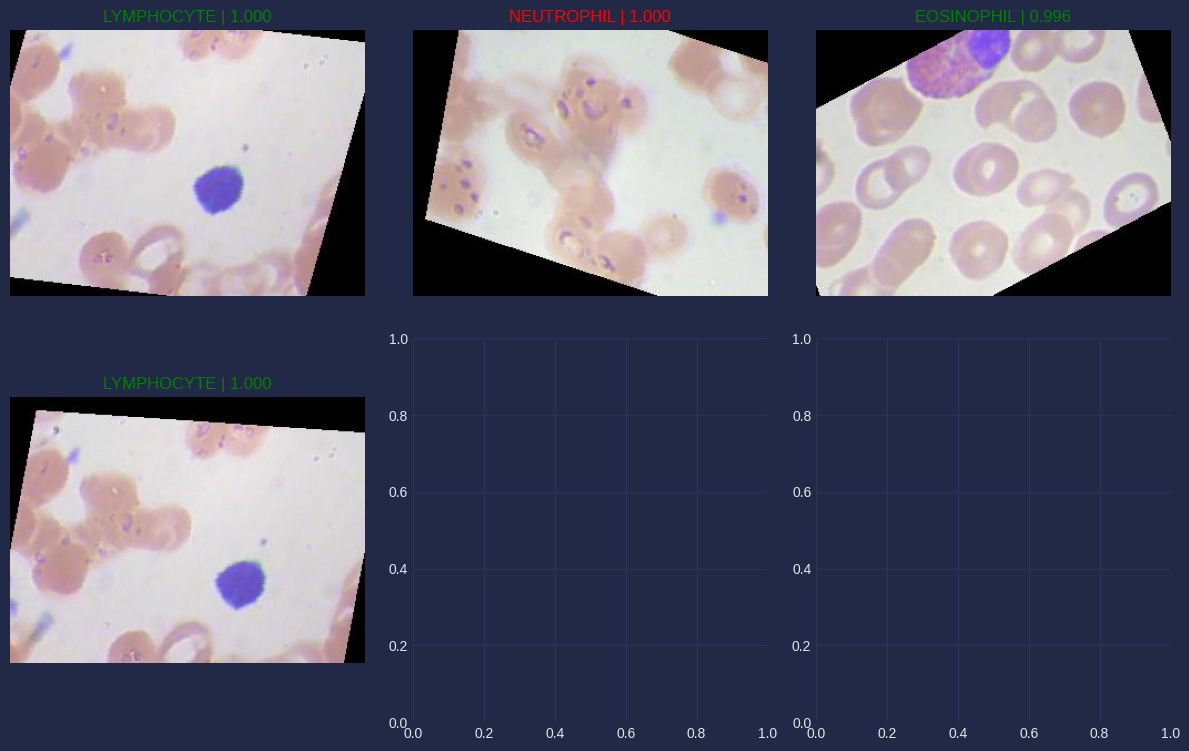

In [70]:
show_predictions(model, test_dataset, idx2class, DEVICE)


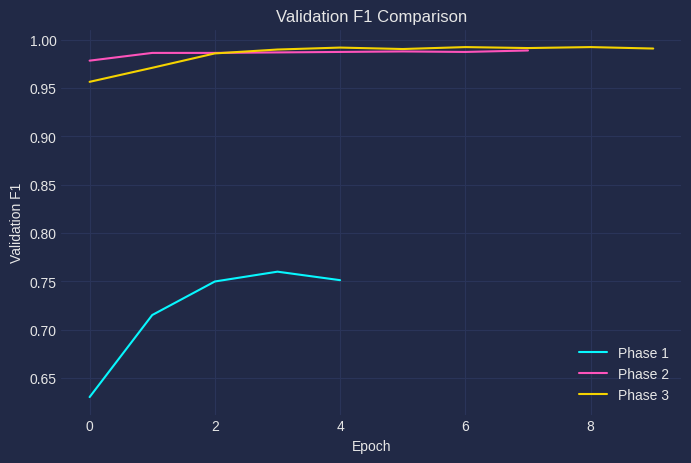

In [71]:
plt.figure(figsize=(8,5))

plt.plot(val_f11, label="Phase 1")
plt.plot(val_f12, label="Phase 2")
plt.plot(val_f13, label="Phase 3")

plt.xlabel("Epoch")
plt.ylabel("Validation F1")
plt.title("Validation F1 Comparison")
plt.legend()
plt.show()


In [72]:
print("Phase 1 time:", train_time1)
print("Phase 2 time:", train_time2)
print("Phase 3 time:", train_time3)

Phase 1 time: 249.67905569699997
Phase 2 time: 443.8611496090001
Phase 3 time: 496.78201191899984


In [73]:
print("Final Test F1:", f1_after3)
print("Final Confusion Matrix:\n", cm_after3)

Final Test F1: 0.8279485313069539
Final Confusion Matrix:
 [[459   9   1 154]
 [  8 599   9   4]
 [ 19   2 429 170]
 [ 59   2   0 563]]


In [74]:
f1_final, cm_final = evaluate(model, test_loader)
print("Final Test F1:", f1_final)


Final Test F1: 0.8279485313069539


In [4]:
os.makedirs("models", exist_ok=True)

torch.save(model.state_dict(), "models/blood_cells.pth")

print("Model saved as blood_cells.pth")


NameError: name 'model' is not defined